# Five-Year S&P 500 Stock Analysis 

---

In [1]:
# optional code visibility 
from IPython.display import HTML
from IPython.display import display

display(HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Click to show code in this notebook')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Click to hide code in this notebook')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" 
    id="toggleButton" value="Click to show code in this notebook"></form>''')) 

## 1. Introduction

The [S&P 500](https://en.wikipedia.org/wiki/S%26P_500_Index) is an American stock market index based on the market capitalizations of [505 large companies](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies) having common stock listed on the NYSE or NASDAQ. It covers about 80 percent of the American equity market by capitalization. The index is weighted by free-float market capitalization, so more valuable companies account for relatively more of the index. 

A variety of performance metrics are calculated and visualized, including returns, volatility, alpha, beta, Sharpe ratio, moving averages. The different stocks/sectors contained in the index are compared in terms of these metrics. The best and worst performing stocks/sectors are identified. The ultimate goal for stock analysis is to design an optimal portforlio and a trading model that can potentially allow maximized returns, but this is beyond this current notebook and will be explored in a separate notebook. 

### Data
The price data for all individual stocks contained in the index were obtained from Google Finance, and then concatenated into a master file. Also included is the price data of SPDR S&P 500 trust ETF (designed to track the S&P 500 stock market index) to be the reference. A script was used get the data and create the file (`get_data.py`). The information of Global Industry Classification Standard (GICS) sector of each stock was also aquired and included in the the `Sector` attribute of the final data. The final data contains the following fields: 
> - `Date`: date in the format of YYYY-MM-DD
> - `Open`: the stock open price 
> - `High`: the highest price of the day 
> - `Low`: the lowest price of the day  
> - `Close`: the stock close price 
> - `Volume`: the stock trading volume 
> - `Name`: the stock ticker symbol 
> - `Sector`: the GICS sector name 

## 2. Analysis


### 2.1 Load Data

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import seaborn as sns
sns.set_style('white')
%matplotlib inline

# import customer functions
from vis import plot_candlestick_ohlc
from helper import get_close_price, calculate_metrics

In [3]:
# read data
data = pd.read_csv('./data/all_sp500_data_2.csv')
print('First 5 Rows of the dataset: ')
display(data.head())

First 5 Rows of the dataset: 


,Date,Open,High,Low,Close,Volume,Name,Sector
0,2012-08-14,89.49,89.65,87.76,87.87,5486506.0,CAT,Industrials
1,2012-08-15,87.25,87.73,86.16,87.61,6346120.0,CAT,Industrials
2,2012-08-16,87.74,88.83,87.23,88.59,4979566.0,CAT,Industrials
3,2012-08-17,89.86,90.10,89.10,90.01,7849959.0,CAT,Industrials
4,2012-08-20,89.74,90.48,89.23,90.44,5298310.0,CAT,Industrials


In [4]:
print('Information of the dataset: ')
display(data.info())

Information of the dataset: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605586 entries, 0 to 605585
Data columns (total 8 columns):
Date      605586 non-null object
Open      605203 non-null float64
High      605376 non-null float64
Low       605361 non-null float64
Close     605586 non-null float64
Volume    605181 non-null float64
Name      605586 non-null object
Sector    605586 non-null object
dtypes: float64(5), object(3)
memory usage: 37.0+ MB


None

In [5]:
print('Number of missing values in each column: ')
display(pd.isnull(data).sum()) 

Number of missing values in each column: 


Date        0
Open      383
High      210
Low       225
Close       0
Volume    405
Name        0
Sector      0
dtype: int64

In [6]:
print('Unique number of stocks (excluding SPY): {}'.format(data['Name'].nunique() - 1))
print('Unique number of sectors: {}'.format(data['Sector'].nunique() - 1))

Unique number of stocks (excluding SPY): 501
Unique number of sectors: 11


In [7]:
# get how many stocks in each sector
sector = data[['Sector', 'Name']].drop_duplicates()
print('Sector size (number of stocks in sector): ')
display(sector.groupby(['Sector'])['Name'].count())

Sector size (number of stocks in sector): 


Sector
Consumer Discretionary        83
Consumer Staples              35
Energy                        31
Financials                    68
Health Care                   61
Industrials                   65
Information Technology        69
Materials                     26
Real Estate                   31
SPY                            1
Telecommunication Services     4
Utilities                     28
Name: Name, dtype: int64

> **Data Summary:** 
> * The dataset contains 605,586 rows and 8 columns.  
> * `Open`, `High`, `Low`, and `Volume` contain missing values (less than 0.1%). `Close` has no missing values.  
> * There are 501 unique stocks (not including SPY) in the dataset and they belong to 11 unique sectors. The largest sector is Consumer Discretionary, and the smallest is Telecommunication Services. 

***

### 2.2 Example Stocks -  Performance Metrics

The top 5 stocks with the highest S&P 500 component weights are **AAPL** (3.92), **MSFT** (2.68), **FB** (1.90), **AMZN** (1.83), **JNJ** (1.71). Some common metrics including returns, volatility, alpha, beta, Sharpe ratio, moving averages of these stocks are analyzed below.  

*Note: **SPY** is also included in the analysis to serve as reference.*

#### *CLOSE PRICE*

In [8]:
# construct a data frame with close price of the 5 stocks
tickers = ['AAPL', 'MSFT', 'FB', 'AMZN', 'JNJ', 'SPY']
close = get_close_price(data, tickers)

print('First 5 rows of the close price dataset: ')
display(close.head())

First 5 rows of the close price dataset: 


,AAPL,MSFT,FB,AMZN,JNJ,SPY
Date,,,,,,
2012-08-14,90.24,30.13,20.38,233.19,68.64,140.79
2012-08-15,90.12,30.20,21.20,237.42,68.35,140.95
2012-08-16,90.91,30.78,19.87,241.55,68.20,142.01
2012-08-17,92.59,30.90,19.05,241.17,67.80,142.22
2012-08-20,95.02,30.74,20.01,240.35,67.70,142.22


In [9]:
print('Statistics of the close price for selected stocks: ')
display(close.describe())

Statistics of the close price for selected stocks: 


,AAPL,MSFT,FB,AMZN,JNJ,SPY
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000
mean,101.096733,45.940525,81.728967,493.512107,100.797687,194.980771
std,25.009571,12.216807,39.772139,230.863315,16.124040,27.457270
min,55.790000,26.370000,17.730000,220.600000,67.210000,135.700000
25%,77.702500,36.077500,49.837500,305.125000,92.090000,177.200000
50%,100.750000,45.390000,78.730000,384.730000,100.855000,200.205000
75%,117.160000,54.350000,115.022500,698.252500,112.690000,210.940000
max,161.060000,74.220000,172.450000,1052.800000,136.570000,247.870000


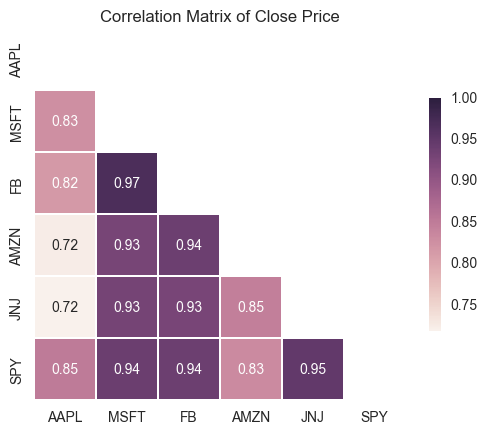

In [10]:
# calculate correlation matrix
corr = close.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# plot correlation matrix
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(corr, mask=mask, square=True, linewidths=.5, annot=True, 
            cbar_kws={"shrink": .5})
ax.set_title('Correlation Matrix of Close Price');

> **Observation:**  
> Overall, these stocks are highly correlated, with correlation coefficients close to 1. Among these stocks, Apple stock shows relatively weaker correlations with other stocks. 

#### *RETURN: 5-Year Simple Return* 

The dataset contains 5 years of stock price data. We can use this to calculate 5-year simple return. Simple return is the incremental amount of net income from an investment, divided by the investment in it. 

> Simple Return = (Current Price - Purchase Price) / Purchase Price 

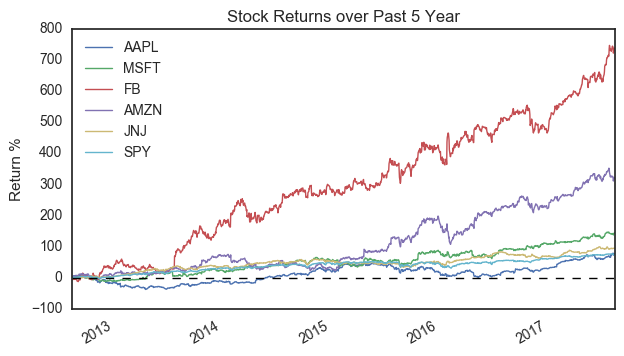

In [24]:
close_copy = close.copy() # make a copy of the close dataframe to make changes

# get close price ratio to that of the 2012-08-14
close_copy = (close_copy - close_copy.ix[0, :])/close_copy.ix[0, :]*100 

# plot price ratio over time
close_copy.plot(legend=True, figsize=(7, 4), linewidth=1)
plt.axhline(y=0, linestyle='dashed', color='black', linewidth=1)
plt.xlabel('')
plt.ylabel('Return %')
plt.title('Stock Returns over Past 5 Year');

> **Observations:**  
> * Facebook stock stands out from the plot with over 700% returns over the past five years 
> * Amazon stock comes next to Facebook in terms of 5-year simple return 
> * Apple, Johnson & Johnson, and Microsoft stocks show returns comparable to that of SPY

#### *RETURN: Annualized Return* 

Annualized return is a percentage value showing how much an investment has increased in value on average per year over a period of time. It can be a preferable metric to use over simple return when we want to evaluate how successful an investment has been, or to compare the returns of two investments. 

> Annualized Return = (Simple Return + 1) ^ (1 / Years Held) - 1

Using the 5-year simple return, the annualized returns of these stocks are calculated and compared. 

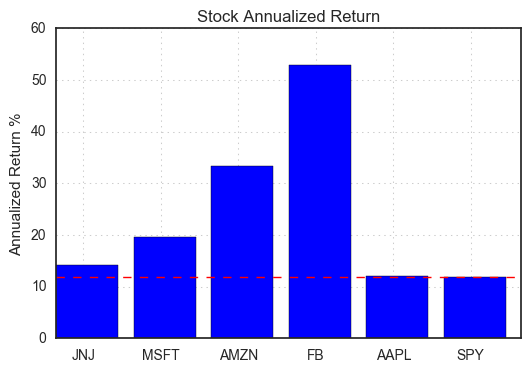

In [12]:
# calculate annualized return with the 5-year simple return
annual_retn = {}
for t in close_copy.columns:
    annual_retn[t] = ((close_copy[t][-1:].values/100 + 1)**(1/5) - 1)*100

ind = np.arange(len(annual_retn))
width = 0.35
fig, ax = plt.subplots()
ax.bar(ind, list(annual_retn.values()), color='blue')
plt.axhline(y=annual_retn['SPY'], linestyle='dashed', color='red', linewidth=1)
ax.set_ylabel('Annualized Return %')
ax.set_title('Stock Annualized Return')
ax.set_xticks(ind + width)
ax.set_xticklabels(list(annual_retn.keys()))
ax.grid(True, linestyle=':', linewidth=0.75);

> **Observations:** 
> * These stocks all beat SPY (Apple only by very slightly) in terms of annualized return 
> * Facebook and Amazon realize over 50% and over 30% annualized returns, respectively, which significantly outperform SPY 

#### *RETURN: Daily Returns*   

Stock prices change on a daily basis, so we can also calculate daily returns to monitor the magnitude of the investment value.

> Daily Return = (Close Price Today - Close Price Yesterday) / Close Price Yesterday

In [13]:
# daily returns of these stocks
close_copy = close.copy() 
daily_retn = close_copy.pct_change().dropna()
print('First 5 rows of the daily return dataset: ')
display(daily_retn.head())

First 5 rows of the daily return dataset: 


,AAPL,MSFT,FB,AMZN,JNJ,SPY
Date,,,,,,
2012-08-15,-0.001330,0.002323,0.040236,0.018140,-0.004225,0.001136
2012-08-16,0.008766,0.019205,-0.062736,0.017395,-0.002195,0.007520
2012-08-17,0.018480,0.003899,-0.041268,-0.001573,-0.005865,0.001479
2012-08-20,0.026245,-0.005178,0.050394,-0.003400,-0.001475,0.000000
2012-08-21,-0.013681,0.001952,-0.042479,-0.003745,0.001182,-0.003234


In [14]:
print('Statistics of the daily return for selected stocks: ')
display(daily_retn.describe())

Statistics of the daily return for selected stocks: 


,AAPL,MSFT,FB,AMZN,JNJ,SPY
count,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000
mean,0.000579,0.000812,0.001941,0.001312,0.000566,0.000476
std,0.015743,0.014214,0.022723,0.018294,0.008615,0.007732
min,-0.123519,-0.113995,-0.090551,-0.109972,-0.032696,-0.040884
25%,-0.006947,-0.006175,-0.008964,-0.007570,-0.003694,-0.003040
50%,0.000442,0.000311,0.001085,0.000857,0.000299,0.000501
75%,0.008875,0.007764,0.012078,0.010861,0.005486,0.004783
max,0.082044,0.104522,0.296115,0.141311,0.049585,0.039791


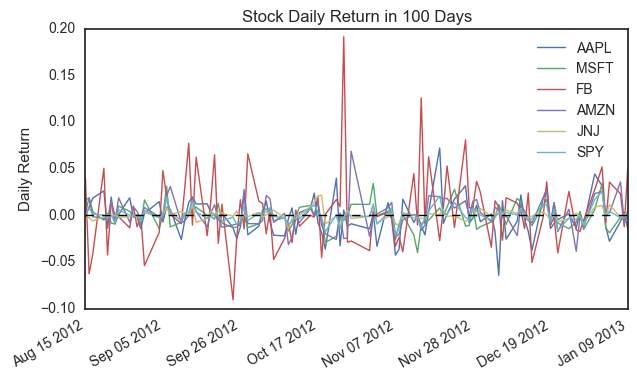

In [17]:
# plot daily return for 100 day period for clarity
daily_retn.iloc[:100].plot(legend=True, figsize=(7, 4), linewidth=1)
plt.axhline(y=0, linestyle='dashed', color='black', linewidth=1)
plt.ylabel('Daily Return')
plt.xlabel('')
plt.title('Stock Daily Return in 100 Days');

> **Observation:** 
> * Stock price fluctuates every day, and the stock daily return fluctuates around 0. All the above stocks have an average daily return slightly above 0.  
> * Facebook stock price fluctuates the most, as demmonstrated in the plot and from its daily return standard deviation.  

#### *VOLATILITY - Standard Deviation*  

From daily return, we can calculate the volatility of a stock. Volatility is a statistical measure of the dispersion of returns for a given stock. Volatility is commonly measured by using the standard deviation of the returns from the stock. Commonly, the higher the volatility, the riskier the stock, i.e., the price of the stock can change dramatically over a short time period in either direction.  

> Daily Volatility = Standard Deviation of Daily Return  
> Annualized Volatility = Daily Volatility * Squar Root of Number of Trading Days in a Year

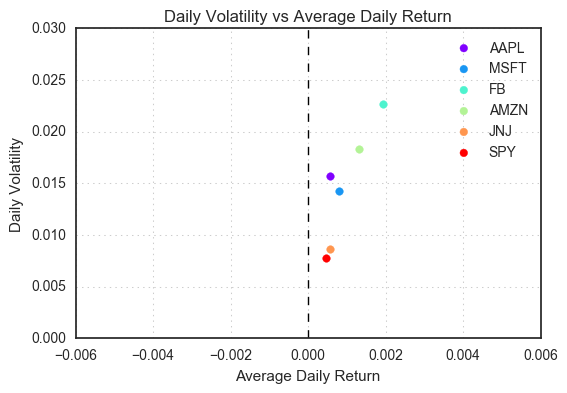

In [19]:
# plot daily volatility vs average daily return
colors = cm.rainbow(np.linspace(0, 1, len(daily_retn.columns)))
fig, ax = plt.subplots(figsize=(6, 4))

for l, x, y, c in zip(daily_retn.columns, 
                      daily_retn.mean(), 
                      daily_retn.std(), 
                      colors):
    plt.scatter(x, y, color=c, s=30, label=l)

plt.axvline(x=0, linewidth=1, linestyle='dashed', color='black')

ax.grid(True, linestyle=':', linewidth=0.75)
plt.xlim([-0.006, 0.006])
plt.xlabel('Average Daily Return')
plt.ylabel('Daily Volatility')
plt.title('Daily Volatility vs Average Daily Return')
plt.legend();

> **Note:**  
> This plot shows the relationship between a stock's return and volatility for the selected stocks. Ideally, we would hope to have a 'golden' stock that lies on the lower right of the plot, but in reality, a stock with higher average daily return is usually associated with higher volatility (lying on the top right of the plot as Facebook stock). Among these stocks, Apple stock seems to have an average daily return too small for its risk. 

#### *Sharpe Ratio* 

The **Sharpe ratio** is a risk-adjusted return measurement developed by economist William Sharpe. It is calculated by subtracting the risk-free return, defined as a U.S. Treasury Bond, from the investment's rate of return, and then dividing by the investment's standard deviation of returns. It is useful for comparing funds with *similar historical returns*. A higher Sharpe ratio indicates a higher risk-adjusted return. With the daily return data, we can calculate Sharpe ratio with the following formula: 

> Sharpe Ratio = Mean(stock daily return - risk_free daily return) / Stdv(stock daily return - risk_free daily return)

**Note:** Since the daily risk-free rate of return is very small (close to 0), the Sharpe ratio is roughly equal to the ratio between the average daily return and the daily volatility.

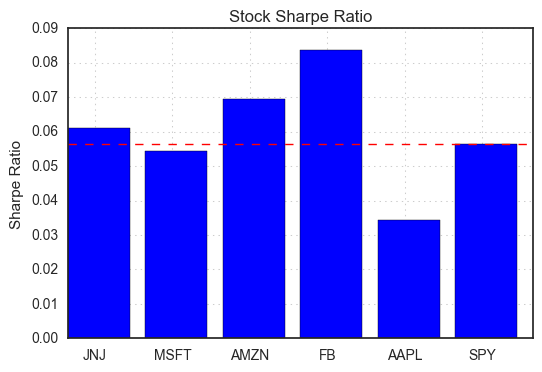

In [20]:
# calculate Sharpe ratio 
daily_rf_retn = (1 + 0.01)**(1/252) - 1 # very small number, approx. 0
daily_retn_adj = daily_retn - daily_rf_retn
sharpe = {}
for t in daily_retn_adj.columns:
    sharpe[t] = daily_retn_adj[t].mean() / daily_retn_adj[t].std()

# plot sharpe ratio
ind = np.arange(len(sharpe))
width = 0.35
fig, ax = plt.subplots()
ax.bar(ind, list(sharpe.values()), color='blue')
plt.axhline(y=sharpe['SPY'], linestyle='dashed', color='red', linewidth=1)
ax.set_ylabel('Sharpe Ratio')
ax.set_title('Stock Sharpe Ratio')
ax.set_xticks(ind + width)
ax.set_xticklabels(list(sharpe.keys()))
ax.grid(True, linestyle=':', linewidth=0.75);

> **Discussion:**  
> As mentioned above, Sharpe ratio is useful for comparing funds with similar historical returns. Here, let's compare Apple stock and Johnson & Johnson stock. From this plot, Apple stock has a much smaller Sharpe ratio than JNJ, indicating that it has a much smaller risk-adjusted return. This is consistent to the Daily Volatility vs Average Daily Return plot, which shows that both stocks have almost the same average daily return but AAPL has much higher volatility, resulting in a smaller risk-adjusted return.   

#### *BETA* 

One measure of relative volatility of a particular stock to the market is its **beta**. Beta is a historical measure of volatility. When standard deviation measures an asset's price movements compared to its average over time, beta measures the asset's volatility *relative to a benchmark* (i.e. an index). A beta of zero implies no correlation between the assets. Any beta above zero would imply a positive correlation with volatility expressed by how much over zero the number is. Any beta below zero would imply a negative correlation with volatility expressed by how much under zero the number is.  

> Beta = Covariance(stock's daily return %, index's daily return %) / Var(index's daily return %)

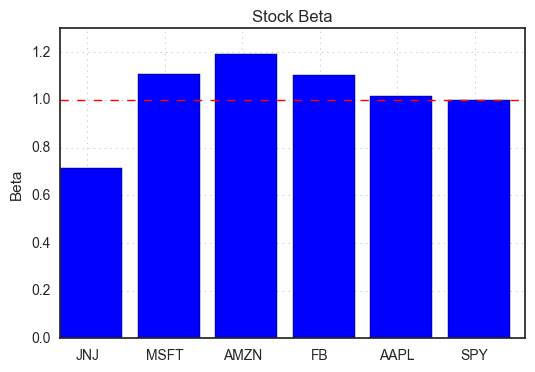

In [22]:
# calculate beta
ref = daily_retn['SPY'].values # SPY as benchmark
beta = {} 
for t in tickers:
    beta[t] = np.cov(daily_retn[t].values, ref)[0][1]/np.var(ref)
    
# plot bar plot of beta
ind = np.arange(len(beta))
width = 0.35
fig, ax = plt.subplots()
ax.bar(ind, list(beta.values()), color='blue')
plt.axhline(y=beta['SPY'], linestyle='dashed', color='red', linewidth=1)
ax.set_ylabel('Beta')
ax.set_title('Stock Beta')
ax.set_ylim((0, 1.3))
ax.set_xticks(ind + width)
ax.set_xticklabels(list(beta.keys()))
ax.grid(True, linestyle=':', linewidth=0.75);

> **Observation:** 
> * All the beta values are above zero, implying positive correlations with the volatility of SPY.  
> * Microsoft, Apple, Amazon, and Facebook stocks have beta values greater than 1, and thus are theoretically more volatile than the benchmark SPY. For example, Amazon stock's beta value is close to 1.2, which implies a volatility 20% greater than SPY  
> * Johnson & Johnson stock has a beta value smaller than 1 (close to 0.7), implying a volatility smaller (30% less) than the benchmark 

#### *ALPHA* 

**Alpha** is the difference between a fund's expected returns based on its beta and its actual returns. It is used to measure performance on a risk adjusted basis. An alpha of zero means the investment has exactly earned a return adequate for the volatility assumed. An alpha over zero means the investment has has earned a return that has compensated for the volatility risk taken. An alpha of less than zero means the investment has earned a return that has not compensated for the volatility risk taken.  

> Alpha =  Stock Return - Risk_Free Return  - beta * (Index Return - Risk_Free Return)

**Comparison between alpha and Sharp ratio:** 
- Similarity: alpha and Sharpe ratio both offer a way to measure returns on a risk-adjusted basis. 
- Difference: alpha applies the measure in relation to a benchmark, whereas Sharpe ratio is based on its own standard deviation (volatility in absolute term). 
- Usage: for investors seeking an investment that closely matches the performance of a chosen benchmark, alpha is the number to review. But a fund's R-squared must be high for alpha to be meaningful. Sharpe ratio is meaningful all the time, and it can be used to compare funds of all types, e.g., stock or bond, because standard deviation is calculated the exact same way for any type of fund but different benchmarks will be used to calculate beta, and beta-based alpha. 

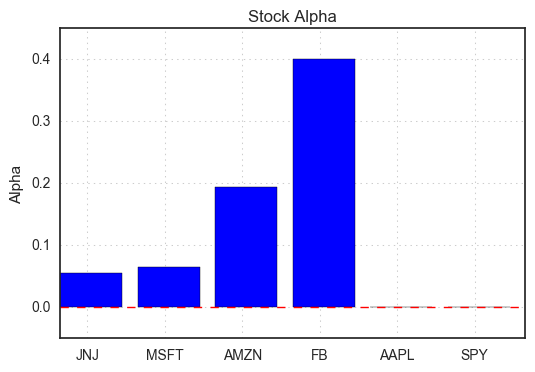

In [23]:
# calculate alpha
# use anualized return for the stock's and index's returns
# use 1.0% as the annual risk-free return
alpha = {}
for i, (k, v) in enumerate(beta.items()):
    alpha[k] = annual_retn[k]/100 - 0.01 - v*(annual_retn['SPY']/100 - 0.01)
    
# plot alpha 
ind = np.arange(len(alpha))
width = 0.35
fig, ax = plt.subplots()
ax.bar(ind, list(alpha.values()), color='blue')
plt.axhline(y=alpha['SPY'], linestyle='dashed', color='red', linewidth=1)
ax.set_ylabel('Alpha')
ax.set_title('Stock Alpha')
ax.set_ylim((-0.05, 0.45))
ax.set_xticks(ind + width)
ax.set_xticklabels(list(alpha.keys()))
ax.grid(True, linestyle=':', linewidth=0.75);

> **Observation:**  
> With SPY as the benchmark, all stocks except Apple stock have alpha much greater than 0. Facebook stock has the largest alpha value of 0.4, implying that it can potentially generate 40% excess return over SPY after adjusting for the inherited market risk (beta).

#### MOVING AVERAGE - Look at an Individual Stock  

After comparing these metrics, we can now look into more details of one individual stock, for example, the 'winner' stock FB.  

Above, we visualize the stock price changes (calculated with close price) using line charts. But there are other prices in one day, including open, high, low, and close. A [candlestick chart](https://en.wikipedia.org/wiki/Candlestick_chart) can be used to see all four variables in one plot. Candlesticks are usually composed of the body and an upper and a lower shadow (or wick). The body illustrates the opening and closing trades. The wick illustrates the highest and lowest traded prices during the time interval represented.   

![candlestick](./images/candlestick.png)

As shown above, stock data has 'noises', i.e., random price fluctuations. **Moving average** can be used to help smooth out short-term fluctuations and highlight longer-term trends or cycles. Given a series of numbers and a fixed subset size, the first element of the moving average is obtained by taking the average of the initial fixed subset of the number series. Then the subset is modified by "shifting forward"; that is, excluding the first number of the series and including the next value in the subset. 

Below is a candlestick plot of Facebook stock in the past year with 20-day, 50-day, and 200-day moving averages. 

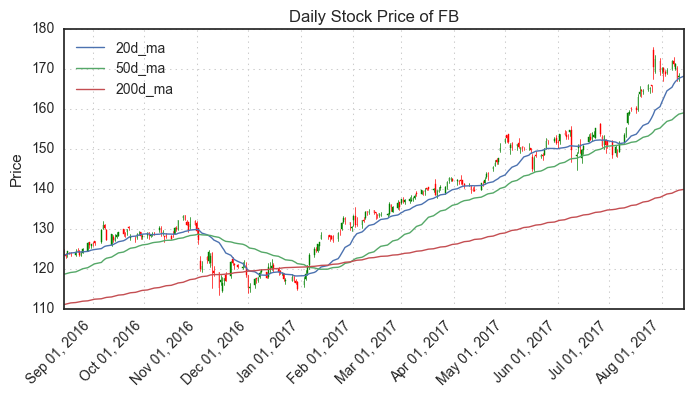

In [25]:
# the plot_candlestick_ohlc is defined in vis.py 
plot_candlestick_ohlc(data, stick='Daily', ticker='FB', ma=True, ma_interval=[20, 50, 200], 
                      start_date='2016-08-14', end_date='2017-08-14')

> **Note:**  
> The green box from the candlestick chart indicates a month of *gain* with the close price higher than the open price. The red box indicates a month of *loss* with the close price lower than the open price. 

> From the above plot, we can see that a moving average is much smoother than the actua stock data. Moving average is thus a stronger indicator of the stock price. A stock needs to be above or below the moving average line in order for the line to change direction. Therefore, crossing a moving average signals a possible change in trend, and should draw attention.

---

### 2.3 All Stock 

After looking at these different aspects of the example stock data, it is time to extend the analyses to all stocks contained in the S&P 500 index and find out the best and worst performing stocks. 

> **Note:** some stocks do not have all 5-year data and are not included in the analysis. 

In [4]:
all_tickers = [] 
length = len(data[data['Name'] == 'SPY'].index)
for t in data['Name'].unique():
    if len(data[data['Name'] == t].index) == length:
        all_tickers.append(t)
print('Number of stocks with 5-year data: {}'.format(len(all_tickers)))

Number of stocks with 5-year data: 446


In [5]:
# compile the stock's close price into one dataframe
close_all = get_close_price(data, all_tickers)

In [6]:
# calculate all the metrics for these stocks
# calculate_metrics() defined in helper.py
metrics_all = calculate_metrics(close_all, all_tickers)
print('First 5 rows of the metrics dataframe: ')
display(metrics_all.head())

First 5 rows of the metrics dataframe: 


,alpha,annual_retn,avg_daily_retn,beta,sharpe,total_retn,volatility
CAT,-0.081983,0.052911,0.000310,1.150359,0.018670,0.294071,0.014472
CAH,-0.002453,0.109155,0.000503,0.935871,0.034549,0.678652,0.013430
D,0.010157,0.077435,0.000347,0.527566,0.030775,0.451963,0.009979
DRE,0.050771,0.156508,0.000653,0.881799,0.050206,1.068916,0.012228
IR,-0.000697,0.139535,0.000631,1.199528,0.040300,0.921494,0.014677


#### *RANK - by Individual Stocks*

In [14]:
print('Stocks with the highest 5-year return: ')
display(metrics_all.sort_values(by='total_retn', 
                                ascending=False)['total_retn'].head())

print('Stocks with the lowest 5-year return: ')
display(metrics_all.sort_values(by='total_retn', 
                                ascending=True)['total_retn'].head())

Stocks with the highest 5-year return: 


NFLX    18.387755
NVDA    10.542152
EA       8.214005
FB       7.378312
INCY     5.919452
Name: total_retn, dtype: float64

Stocks with the lowest 5-year return: 


CHK   -0.788131
RRC   -0.744488
UAA   -0.666253
MOS   -0.647579
NOV   -0.598479
Name: total_retn, dtype: float64

In [15]:
print('Stocks with the highest annualized return: ')
display(metrics_all.sort_values(by='annual_retn', 
                                ascending=False)['annual_retn'].head())

print('Stocks with the lowest annualized return: ')
display(metrics_all.sort_values(by='annual_retn', 
                                ascending=True)['annual_retn'].head())

Stocks with the highest annualized return: 


NFLX    0.809279
NVDA    0.631013
EA      0.559156
FB      0.529788
INCY    0.472361
Name: annual_retn, dtype: float64

Stocks with the lowest annualized return: 


CHK   -0.266815
RRC   -0.238829
UAA   -0.197059
MOS   -0.188269
NOV   -0.166815
Name: annual_retn, dtype: float64

In [16]:
print('Stocks with the lowest volatility (standard deviation): ')
display(metrics_all.sort_values(by='volatility', 
                                ascending=True)['volatility'].head())

print('Stocks with the highest volatility (standard deviation): ')
display(metrics_all.sort_values(by='volatility', 
                                ascending=False)['volatility'].head())

Stocks with the lowest volatility (standard deviation): 


SPY    0.007732
PEP    0.008243
JNJ    0.008615
WM     0.008725
RSG    0.008850
Name: volatility, dtype: float64

Stocks with the highest volatility (standard deviation): 


HPQ    0.075218
CHK    0.040829
FCX    0.034134
DVA    0.033393
JEC    0.032622
Name: volatility, dtype: float64

In [17]:
print('Stocks with the highest Sharpe ratio: ')
display(metrics_all.sort_values(by='sharpe', 
                                ascending=False)['sharpe'].head())

print('Stocks with the lowest Sharpe ratio: ')
display(metrics_all.sort_values(by='sharpe', 
                                ascending=True)['sharpe'].head())

Stocks with the highest Sharpe ratio: 


NOC     0.103468
FISV    0.098225
NVDA    0.096966
EA      0.094236
LUV     0.089887
Name: sharpe, dtype: float64

Stocks with the lowest Sharpe ratio: 


MOS   -0.033347
RRC   -0.029155
NOV   -0.028653
MAT   -0.026853
CTL   -0.025788
Name: sharpe, dtype: float64

In [18]:
print('Stocks with the lowest beta: ')
display(metrics_all.sort_values(by='beta', 
                                ascending=True)['beta'].head())

print('Stocks with the highest beta: ')
display(metrics_all.sort_values(by='beta', 
                                ascending=False)['beta'].head())

Stocks with the lowest beta: 


ED     0.350578
SO     0.384824
DUK    0.451130
EIX    0.463275
AWK    0.484815
Name: beta, dtype: float64

Stocks with the highest beta: 


FCX    1.958471
URI    1.859497
MU     1.761376
CHK    1.750542
LNC    1.683014
Name: beta, dtype: float64

In [19]:
print('Stocks with the highest alpha: ')
display(metrics_all.sort_values(by='alpha', 
                                ascending=False)['alpha'].head())

print('Stocks with the lowest alpha: ')
display(metrics_all.sort_values(by='alpha', 
                                ascending=True)['alpha'].head())

Stocks with the highest alpha: 


NFLX    0.659643
NVDA    0.489420
EA      0.428524
FB      0.399971
STZ     0.345713
Name: alpha, dtype: float64

Stocks with the lowest alpha: 


CHK   -0.466871
FCX   -0.388349
RRC   -0.365522
MRO   -0.345597
UAA   -0.334458
Name: alpha, dtype: float64

#### *RANK - by Sector*

In [22]:
# add sector to the metrics dataframe
sector = data[['Name', 'Sector']].drop_duplicates()
sector.set_index(['Name'], inplace=True)
metrics_merged = pd.concat([metrics_all, sector], axis=1).dropna()

# calculate mean metrics
grouped = metrics_merged.groupby('Sector').mean()

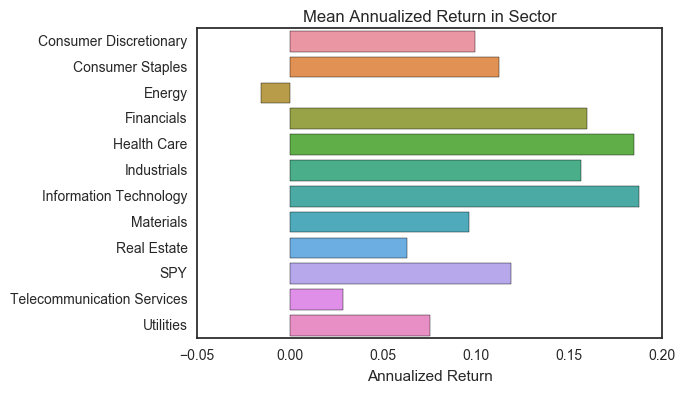

In [34]:
# plot annual_retn
sns.barplot(y=grouped.index, x=grouped.annual_retn)
plt.xlabel('Annualized Return')
plt.ylabel('')
plt.title('Mean Annualized Return in Sector');

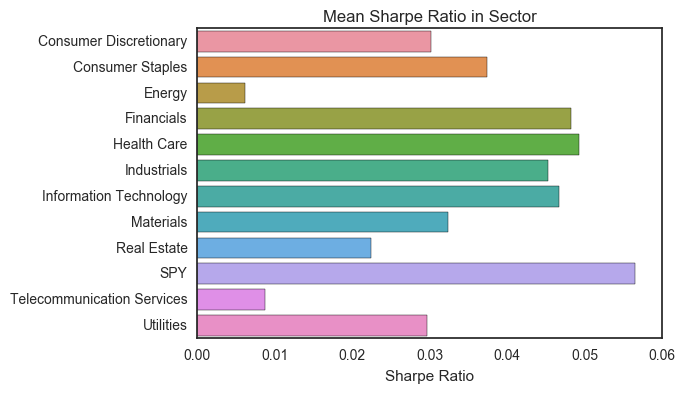

In [36]:
# plot sharpe ratio
sns.barplot(y=grouped.index, x=grouped.sharpe)
plt.xlabel('Sharpe Ratio')
plt.ylabel('')
plt.title('Mean Sharpe Ratio in Sector');

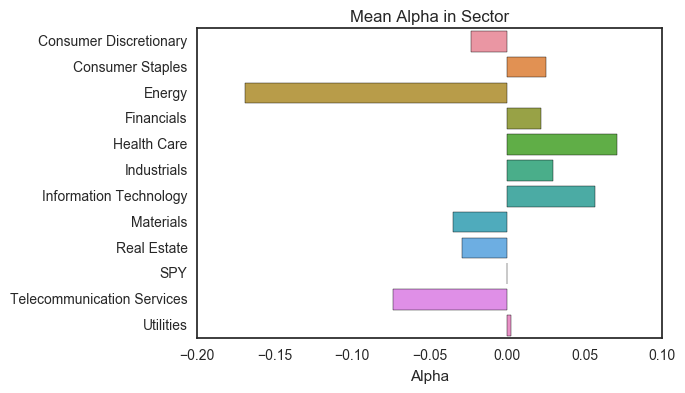

In [37]:
# plot alpha
sns.barplot(y=grouped.index, x=grouped.alpha)
plt.xlabel('Alpha')
plt.ylabel('')
plt.title('Mean Alpha in Sector');

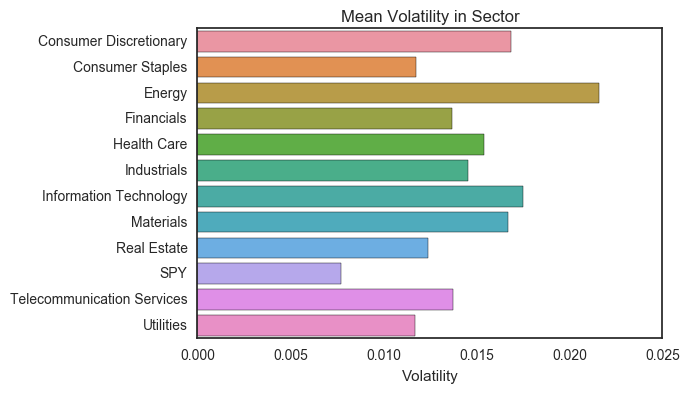

In [40]:
# plot volatility
sns.barplot(y=grouped.index, x=grouped.volatility)
plt.xlabel('Volatility')
plt.ylabel('')
plt.title('Mean Volatility in Sector');

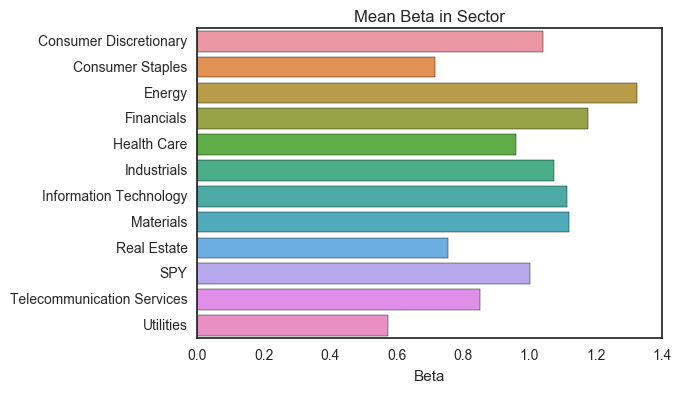

In [38]:
# plot beta
sns.barplot(y=grouped.index, x=grouped.beta)
plt.xlabel('Beta')
plt.ylabel('')
plt.title('Mean Beta in Sector');

> **Observation:**  
> * The best sectors seem to be Health Care and Information Technology, in terms of high annualized return, Sharpe ratio, alpha. 
> * The Energy sector in the most risky sector and realizes the least risk-adjusted return (both alpha, and Sharpe ratio)

## 3. Summary 

In this notebook, common performance metrics including returns, alpha, beta, sharpe ratio, and moving averages are analyzed for stocks contained in the S&P 500 index. The price data of SPY, i.e., SPDR S&P 500 trust ETF (designed to track the S&P 500 stock market index), is used as reference for performance comparisons and also serves as benchmark for calculating alpha and beta. In addition to individual stocks, the averaged performance of different stock sectors in S&P 500 are also compared. 

### Findings 

Given the performance metrics computed in this notebook:   

- Several IT stocks performed really well in the past 5 years, including Netflix (NFLX), Nvdia (NVDA), Facebook (FB), and Electronic Arts (EA).  
- Some Energy stocks had performance among the worst, including Chesapeake Energy (CHK), Range Resources (RRC), National Oilwell (NOV), etc.   
- The best-performing sector is found to be Health Care and Information Technology and the worst-performing one is Energy.  

### Next Steps

Some next steps include: 
- Design and evaluate portfolio holdings and trading strategies 
- Build predictive machine learning models to give recommendations on trading actions